# ANALYSIS AND PREDICTION OF CONNECTICUT HOME PRICES




## 1. Introduction

For this project I want to analyze the housing trends for Connecticut. Housing trends depend on multiple factors, some of
the main ones being the Federal Interest Rate, the Gross Domestic Product of the country, the Gross Domestic Product of the 
state, population change, and the desirability of the county or town. Also, because of COVID-19 and the large amount of jobs
becoming remote, there is a trend of people leaving cities. With Connecticut being next to New York City and already having
a significant proportion of the State's residents commuting to New York City, I would expect a rise in housing cost and a 
population increase in the forseeable future. With this project I am going to examine the housing and population trends and
will impliment a Linear Regression model to predict future housing prices. 


**Necessary Libraries**
- Pandas: For dataframe manipulation and display
- Seaborn: For plots
- Matplotlib: For plot formation
- Scikit-learn: For our Linear Regression model and prediction
- DateUtil: To add dates into our dataframes
- Statsmodels.api: So we can calculate and summarize our model statistics

In [1089]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mpl
import matplotlib.dates as mdates
import sklearn
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

## 2. Data Collection and Scrubbing

For our data I downloaded a few csv's from a couple of economic websites (I'll link them at the end of the tutorial). We have
a Connecticut GDP and population csv from 2001 to 2020, a US GDP and population csv from the same time period, a cvs of 
federal interest rates and finally a csv of home sales in Connecticut from every county and town over the past 20 years. The 
reason I'm including the GDP, population and federal interest rate is because those are big economic factors in the housing
market. Usually a low federal interest rate and an increase in Per Capita or GDP of the country/state attributes to the 
growth of the housing market. While higher federal interest rates and a decrease in GDP or Per Capita of a country or state
slows the housing market. 

In [1090]:
ct_gdp_pop = pd.read_csv('CT_Real_GDP_Pop.csv')
ct_home_sales = pd.read_csv("CT Single Family Home Sales - Monthly.csv")
us_per_cap = pd.read_csv('US_Real_Per_Cap.csv')
fed_rate_df = pd.read_csv("fed_interest_rates.csv")

Now we are going to take a look at the dataframes that were created and see if we can combine a few or clean up any NaN values.
We are also going to perform data manipulation and make new columns in dataframes to help us understand the big picture.

In [1091]:
ct_gdp_pop.head()

,DATE,CTRQGSP,Population
0,1/1/2001,219932000000.00,3432835
1,4/1/2001,219938000000.00,3432835
2,7/1/2001,219947000000.00,3432835
3,10/1/2001,219955000000.00,3432835
4,1/1/2002,219957000000.00,3458749


In [1092]:
fed_rate_df.head()

,date,value
0,1/1/2001,5.41
1,1/2/2001,6.67
2,1/3/2001,6.35
3,1/4/2001,5.92
4,1/5/2001,5.83


One thing I noticed was that in our us_per_cap dataframe, there is a column labeled Real_US_GDP when it is actually the Real 
Per Capita of the US. So, we are going to rename that column real quick in order to not get confused later on.

In [1093]:
us_per_cap.rename(columns={'Real_US_GDP':'US_Per_Cap'}, inplace=True)
us_per_cap.head()

,DATE,US_Per_Cap
0,1/1/2001,46531
1,4/1/2001,46693
2,7/1/2001,46378
3,10/1/2001,46386
4,1/1/2002,46690


In [1094]:
ct_home_sales.head()

,Year - Qtr,Town,County,Total Sales,Med. Sales Price,Avg. Price,Min. Price,Max. Price
0,2001-Jan,Ashford,Windham,5,124800,114510.40,61352,164900
1,2001-Jan,Woodstock,Windham,9,126600,135955.56,77000,245000
2,2001-Jan,Newington,Hartford,35,136000,136620.00,40000,239900
3,2001-Jan,West Hartford,Hartford,58,177500,180148.14,31686,800000
4,2001-Jan,Canton,Hartford,9,189000,191833.33,60000,416000


For the Federal Interest Rate dataframe we will get the average for the whole month instead of the daily rate and drop any
data after the year 2020. Then we will drop the NaN column in the US_GDP dataframe, rename the columns and then add the Average
Fed Rate per month that we just calculated as a new column in the US_GDP dataframe to condense the two dataframes. Then we 
will concatenate the US_GDP dataframe and CT_GDP dataframe together to bring our total dataframes to two, the CT_Home_Sales 
dataframe and the new CT_US_GDP dataframe. 

In [1095]:
fed_rate_df.dropna(axis=0)
fed_df = pd.DataFrame(columns=['date', 'Avg_Fed_Rate'])
fed_rate_df['date'] = pd.to_datetime(fed_rate_df['date'])

for year, group in fed_rate_df.groupby(fed_rate_df.date.dt.year):
    for month, groups in group.groupby(group.date.dt.month):
        
        fed_df = fed_df.append(pd.DataFrame({'date':year
                                             , 'Avg_Fed_Rate':groups[' value'].mean()}, index=[0]), ignore_index = True)
fed_df = fed_df[fed_df['date'] < 2021]
fed_df.head()

,date,Avg_Fed_Rate
0,2001,5.98
1,2001,5.49
2,2001,5.31
3,2001,4.80
4,2001,4.21


Now we want to calculate the Per Capita of Connecticut given the GDP and Population of the state. Then we will drop the GDP and
Population columns because we have a Gross Domestic Product per person figure. Finally, we will merge the US real
Per Capita dataframe with the Connecticut Per Capita Dataframe

In [1096]:
ct_gdp_pop['CT_Per_Cap'] = ct_gdp_pop['CTRQGSP']/ct_gdp_pop[' Population']
ct_gdp_pop.drop(columns=['CTRQGSP',' Population'], inplace=True)
us_ct_per_cap = us_per_cap.merge(ct_gdp_pop, how='left', on='DATE')
us_ct_per_cap['DATE'] = pd.to_datetime(us_ct_per_cap['DATE'])
us_ct_per_cap.head()

,DATE,US_Per_Cap,CT_Per_Cap
0,2001-01-01,46531,64067.16
1,2001-04-01,46693,64068.91
2,2001-07-01,46378,64071.53
3,2001-10-01,46386,64073.86
4,2002-01-01,46690,63594.38


In [1097]:
us_change = us_ct_per_cap['US_Per_Cap'].pct_change()
ct_change = us_ct_per_cap['CT_Per_Cap'].pct_change()

monthly_per_cap = pd.DataFrame(columns=['DATE','us_per_cap','ct_per_cap'])
i=1
for row in us_ct_per_cap.iterrows():
    
    monthly_per_cap = monthly_per_cap.append({'DATE':row[1]['DATE'],'us_per_cap':row[1]['US_Per_Cap'], 'ct_per_cap':row[1]['CT_Per_Cap']},
                                                 ignore_index=True)
    if i < 80:
        us_cap = row[1]['US_Per_Cap'] + row[1]['US_Per_Cap']*(us_change[i]/2)
        ct_cap = row[1]['CT_Per_Cap'] + row[1]['CT_Per_Cap']*(ct_change[i]/2)
        date = row[1]['DATE'] + relativedelta(months=1)
        monthly_per_cap = monthly_per_cap.append({'DATE':date, 'us_per_cap':us_cap, 'ct_per_cap':ct_cap}, ignore_index=True)
        monthly_per_cap = monthly_per_cap.append({'DATE':(date+ relativedelta(months=1)), 
                                                  'us_per_cap':(us_cap+row[1]['US_Per_Cap']*(us_change[i]/2))
                                                  , 'ct_per_cap':(ct_cap+ row[1]['CT_Per_Cap']*(ct_change[i]/2))}, ignore_index=True)
        i+=1
    
monthly_per_cap

avg_change_us = us_change.mean()
avg_change_ct = ct_change.mean()
last_row = monthly_per_cap.iloc[-1]

date1 = last_row['DATE'] + relativedelta(months=1)
date2 = date1 + relativedelta(months=1)
nov_us_growth = last_row['us_per_cap'] + last_row['us_per_cap']*(avg_change_us)
dec_us_growth = nov_us_growth + nov_us_growth*avg_change_us
nov_ct_growth = last_row['ct_per_cap'] + last_row['ct_per_cap'] * avg_change_ct
dec_ct_growth = nov_ct_growth + nov_ct_growth*avg_change_ct
end = pd.DataFrame({'DATE':[date1, date2],'us_per_cap':[nov_us_growth, dec_us_growth],'ct_per_cap':[nov_ct_growth, dec_ct_growth]},index=[238,239])
monthly_per_cap = pd.concat([monthly_per_cap,end])
monthly_per_cap

,DATE,us_per_cap,ct_per_cap
0,2001-01-01,46531,64067.16
1,2001-02-01,46612.0,64068.04
2,2001-03-01,46693.0,64068.91
3,2001-04-01,46693,64068.91
4,2001-05-01,46535.5,64070.22
...,...,...,...
235,2020-08-01,56551.0,68829.80
236,2020-09-01,56812.0,69409.50
237,2020-10-01,56812,69409.50
238,2020-11-01,56961.77,69492.00


I noticed that the CT_home_Sales dataframe had dates from this year (2021) and in order to fit the rest of the dates from the
other data we need to trim any sales from 2021 off. This might come in handy later if we want to use this data as a test set
for our linear regression model.

In [1098]:
ct_home_sales['Year - Qtr'] = pd.to_datetime(ct_home_sales['Year - Qtr'])
ct_home_sales = ct_home_sales[ct_home_sales['Year - Qtr'].dt.year < 2021]
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [1099]:
ct_home_sales.describe()

,Total Sales,Med. Sales Price,Avg. Price,Min. Price,Max. Price
count,39308.00,39308.00,39308.00,39308.00,39308.00
mean,24.64,281520.19,316524.77,112608.02,881727.10
std,29.34,324357.58,413076.85,119214.03,4410312.38
min,1.00,2000.00,2000.00,1000.00,2000.00
25%,6.00,172000.00,182825.73,40000.00,320000.00
50%,14.00,229500.00,243356.12,82500.00,450958.00
75%,32.00,308000.00,334247.60,150000.00,745000.00
max,404.00,47200000.00,43593100.49,3400000.00,435000000.00


Taking a look at our description table of the Connecticut home sales, we see that the we are likely going to have some outliers. There is an average max price over 43 million dollars and an average minimum of two thousand dollars. We are going to construct a scatterplot so we can get a quick visual of what our outliers look like.

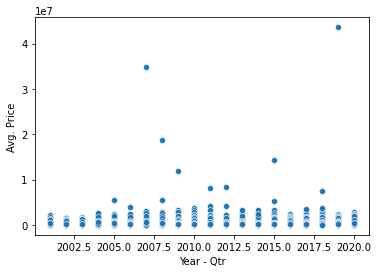

In [1100]:
sns.scatterplot(data=ct_home_sales, x=ct_home_sales['Year - Qtr'].dt.year, y="Avg. Price")
mpl.show()

With the scatterplot we see that there are a few major outliers that skews our data. We want to remove them so those outliers
don't affect our model. We are going to calculate the cutoff for our data by getting rid of any sales price outside of 2 
standard deviations. 

In [1101]:
price_std = np.std(ct_home_sales['Avg. Price'])
price_mean = np.mean(ct_home_sales['Avg. Price'])
cut_off = price_std*2
upper = price_mean + cut_off
outliers = [x for x in ct_home_sales['Avg. Price'] if x > upper]
ct_home_sales = ct_home_sales[~ct_home_sales['Avg. Price'].isin(outliers)]
ct_home_sales.describe()

,Total Sales,Med. Sales Price,Avg. Price,Min. Price,Max. Price
count,38285.00,38285.00,38285.00,38285.00,38285.00
mean,24.33,255905.40,279559.65,106651.85,676258.91
std,29.22,134855.44,157595.82,97382.05,1111662.20
min,1.00,2000.00,2000.00,1000.00,2000.00
25%,6.00,170000.00,181300.00,40000.00,318000.00
50%,14.00,225750.00,239890.67,80000.00,445000.00
75%,31.00,300000.00,323952.08,145000.00,708000.00
max,278.00,1300000.00,1142282.77,1125000.00,67000000.00


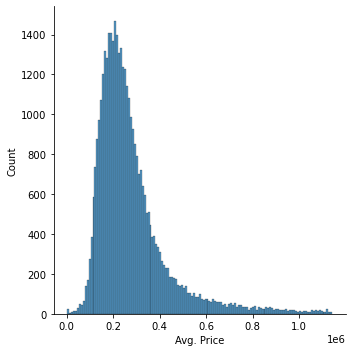

In [1102]:
sns.displot(ct_home_sales, x='Avg. Price')
mpl.show()

From our distribution plot we see that our data is still skewed right after getting rid of any outliers that are three times our standard deviation, because most houses are sold for a modest amount but a few are sold for very large amounts. 


I'm going to get the average home price for Connecticut for the last 20 years so we can add it to the ct_us_gdp dataframe to make it easier to visualize any trends. 

In [1103]:
avg_price = []
count = 0
for year, group in ct_home_sales.groupby(ct_home_sales['Year - Qtr'].dt.year):
    count += 1
    avg_price.append(group['Avg. Price'].mean())
avg_price
ct_us = pd.DataFrame(columns=['DATE','Pop','Annual_Pop_Change', 'CT_Per_Cap'])
ct_us_gdp['CT_Avg_Price'] = avg_price
ct_us_gdp['DATE'] = pd.to_datetime(ct_us_gdp['DATE'])
ct_us_gdp

,DATE,Pop,Annual_Pop_Change,CT_Per_Cap,US_GDP_Growth,US_Annual_Change,Avg_Fed_Rate,CT_Avg_Price
0,2001-01-01,3432835,0.62,50347.45,1.00,-3.13,1.59,217350.53
1,2002-01-01,3458749,0.75,50940.85,1.74,0.74,1.54,237468.74
2,2003-01-01,3484336,0.74,52012.87,2.86,1.12,1.50,262564.83
3,2004-01-01,3496094,0.34,56715.41,3.80,0.94,1.47,287863.70
4,2005-01-01,3506956,0.31,59499.15,3.51,-0.29,1.48,317199.48
5,2006-01-01,3517460,0.30,63373.66,2.85,-0.66,1.50,322137.20
6,2007-01-01,3527270,0.28,67303.50,1.88,-0.98,1.52,330156.31
7,2008-01-01,3545579,0.52,67852.44,-0.14,-2.01,1.52,302556.97
8,2009-01-01,3561807,0.46,66517.25,-2.54,-2.40,1.48,282442.76
9,2010-01-01,3579173,0.49,66510.22,2.56,5.10,1.42,282243.82


If we want to combine the all of the seperate dataframes into one dataframe, then we need to duplicate the federal interest
rate dataframe and monthly per capita of the U.S. and Connecticut by stacking them on top of another. I'm stacking them because
we are going to group by County then by month in the next cell and our values will line up with the dates from our ct_sales
dataframe.

In [1104]:
for i in range(1,4):
    fed_df = fed_df.append(fed_df, ignore_index=True)
    monthly_per_cap = monthly_per_cap.append(monthly_per_cap, ignore_index=True)
fed_df
monthly_per_cap

,DATE,us_per_cap,ct_per_cap
0,2001-01-01,46531,64067.16
1,2001-02-01,46612.0,64068.04
2,2001-03-01,46693.0,64068.91
3,2001-04-01,46693,64068.91
4,2001-05-01,46535.5,64070.22
...,...,...,...
1915,2020-08-01,56551.0,68829.80
1916,2020-09-01,56812.0,69409.50
1917,2020-10-01,56812,69409.50
1918,2020-11-01,56961.77,69492.00


We will create a new dataframe for Connecticut home sales and then append our calculated values. For each county and then for
each month I want the total sales and average of the median price, average price, minimim price and maximum price. After 
we iterate over every county, I'll add the new federal rate and Per Capita columns.

In [1105]:
ct_sales = pd.DataFrame(columns=['Year', 'County','Total_Sales','Med_Price','Avg_Price',
                                             'Min_Price','Max_Price'])

for county, group in ct_home_sales.groupby('County'):
    
    for month, groups in group.groupby('Year - Qtr'):
        ct_sales = ct_sales.append({'Year':month, 'County':county, 'Total_Sales':groups['Total Sales'].sum(), 
                                                    'Med_Price':groups['Med. Sales Price'].mean(), 
                                                    'Avg_Price':groups['Avg. Price'].mean(),
                                                   'Min_Price':groups['Min. Price'].mean(),
                                                   'Max_Price':groups['Max. Price'].mean()},
                                                   ignore_index=True)
ct_sales['fed_rate'] = fed_df['Avg_Fed_Rate']
ct_sales['us_per_cap'] = monthly_per_cap['us_per_cap']
ct_sales['ct_per_cap'] = monthly_per_cap['ct_per_cap']
ct_sales.sort_values(by=['Year'], inplace=True)
ct_sales.reset_index(inplace=True)
ct_sales.drop(columns=['index'], inplace=True)
ct_sales

,Year,County,Total_Sales,Med_Price,Avg_Price,Min_Price,Max_Price,fed_rate,us_per_cap,ct_per_cap
0,2001-01-01,Fairfield,941,362852.38,446749.10,125671.43,1603036.05,5.98,46531,64067.16
1,2001-01-01,Litchfield,174,170993.18,218953.61,101772.41,453671.95,5.98,46531,64067.16
2,2001-01-01,New Haven,869,161361.00,183051.97,58949.89,567411.11,5.98,46531,64067.16
3,2001-01-01,Windham,88,140780.77,145331.48,93265.54,208876.92,5.98,46531,64067.16
4,2001-01-01,New London,186,142870.40,161496.03,74360.80,393094.75,5.98,46531,64067.16
...,...,...,...,...,...,...,...,...,...,...
1915,2020-12-01,Litchfield,346,357362.00,420507.19,158645.00,1016520.00,0.09,57111.93,69574.60
1916,2020-12-01,Hartford,1169,267136.21,285086.24,86476.48,750760.07,0.09,57111.93,69574.60
1917,2020-12-01,Fairfield,1019,504751.84,565039.56,183778.32,1530021.00,0.09,57111.93,69574.60
1918,2020-12-01,Tolland,178,253510.85,262728.44,123189.23,464976.92,0.09,57111.93,69574.60


## Part 3: Exploratory Data Analysis

Exploratory Data Analysis is an important process in the Data Pipeline because we want to see where the trends are. Data tells
a story and what better way for it to tell us that story than to create graphs. To start the analysis I grouped by county again 
because I want to visualize each county's scatterplot. Then I create a polyfit line using numpy to get a good idea of how our
data is moving.


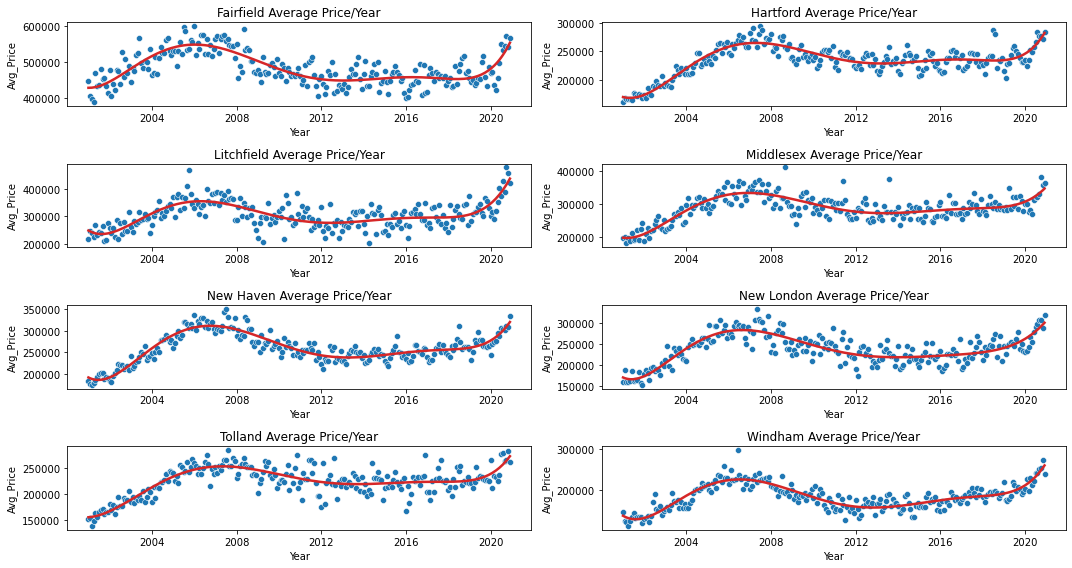

In [1106]:
fig, ax = mpl.subplots(figsize=(15,8))
rows = 4 
cols = 2
i = 1

for county, group in ct_sales.groupby('County'):
    mpl.subplot(rows,cols,i)
    p = sns.scatterplot(data=group, x='Year', y='Avg_Price')
    mpl.title(f'{county} Average Price/Year')
    x = mdates.date2num(group['Year'])
    coefficients = np.polyfit(x, group['Avg_Price'], 7)
    xx = np.linspace(x.min(), x.max(), 100)
    dd = mdates.num2date(xx)
    poly = np.poly1d(coefficients)
    p.plot(x,poly(x), color='C3', alpha=1, lw=2.5)
    i+=1
mpl.tight_layout()


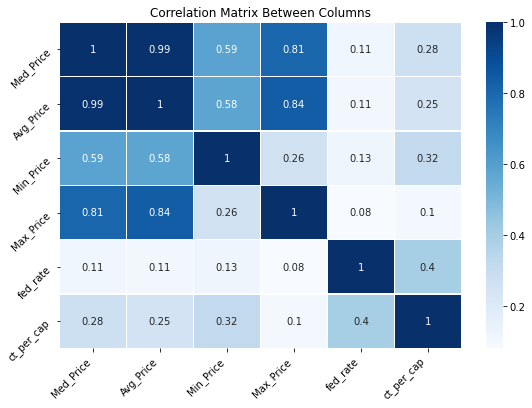

In [1107]:
mpl.figure(figsize=(9,6))
h = sns.heatmap(ct_sales.corr(), cmap='Blues', annot = True, linewidths=0.2)
h.set_title('Correlation Matrix Between Columns')
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
h.set_yticklabels(h.get_yticklabels(), rotation=45, horizontalalignment='right')
mpl.show()

From our heatmap we can see that there is a weak correlation between the federal interest rate and Per Capita of Connecticut,
along with the median, average and minimum price. Looking at this heatmap, we can also conclude that the correlation between
average minimum price, average and median price tells us again that our data is a little skewed towards the right. 


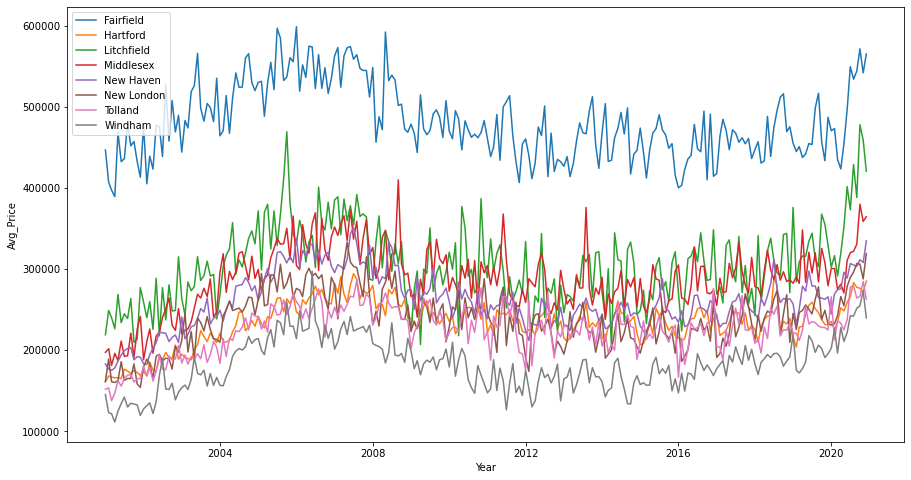

In [1108]:
mpl.figure(figsize=(15,8))
for county, group in ct_sales.groupby('County'):
    p = sns.lineplot(data=group, x='Year', y='Avg_Price', label=county)
p.legend()

Our line plot shows us that Fairfield county consistently has the highest average home prices compared to the other counties.
Windham county has the lowest prices but it's still pretty close to the other counties in terms of average home price. The plot
makes sense because Fairfield county is closest to New York City and it has a lot of commuters living in that region. Windham on the other hand is in the top right corner of Connecticut and it is pretty rural and rural homes tend to be cheaper. 


## 4. Machine Learning Model

I will be using a Linear Regression Model to try to predict the average home price based off of county. I decided to split it up
into multiple Linear Regressions because it gives you more information into the housing market for the state. The nice thing is
that Connecticut only has 8 counties so I won't be printing out a bunch of graphs and ordinary least squares tables. From what 
we saw during the Exploratory Data Analysis portion, there was one county that stood out from the other counties which was
Fairfield, the county closest to New York City. That county would probably skew our Linear Regression model and would not give
an accurate picture of the home prices for Connecticut as a whole. That one county would make it seem like home prices were
higher throughout the whole state which is simply not true as seen from the graphs present in the data analysis phase.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     72.53
Date:                Mon, 17 May 2021   Prob (F-statistic):           6.88e-55
Time:                        09:51:45   Log-Likelihood:                -2776.1
No. Observations:                 240   AIC:                             5568.
Df Residuals:                     232   BIC:                             5596.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.269e+06   3.11e+06     -0.729      

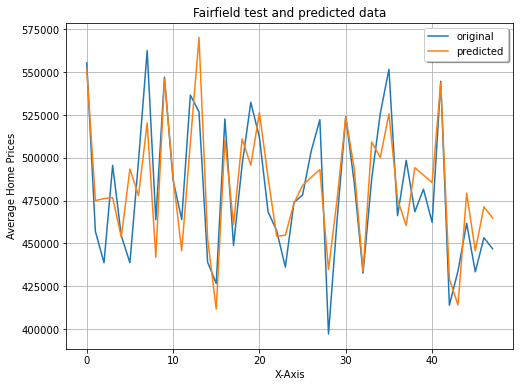

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     183.2
Date:                Mon, 17 May 2021   Prob (F-statistic):           9.04e-91
Time:                        09:51:46   Log-Likelihood:                -2568.2
No. Observations:                 240   AIC:                             5152.
Df Residuals:                     232   BIC:                             5180.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.973e+06   1.29e+06     -6.170      

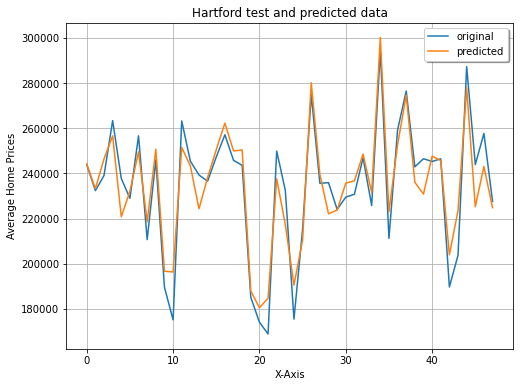

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     336.2
Date:                Mon, 17 May 2021   Prob (F-statistic):          1.24e-117
Time:                        09:51:46   Log-Likelihood:                -2642.8
No. Observations:                 240   AIC:                             5302.
Df Residuals:                     232   BIC:                             5329.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.91e+06   1.75e+06     -1.092      

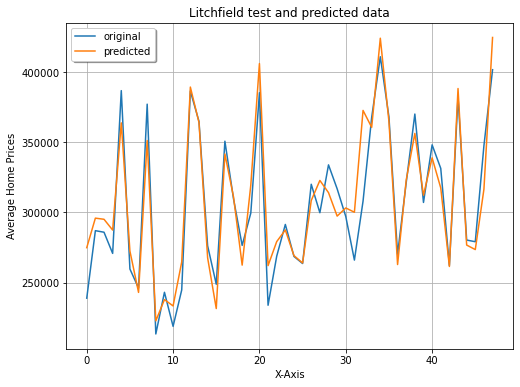

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     187.7
Date:                Mon, 17 May 2021   Prob (F-statistic):           8.57e-92
Time:                        09:51:46   Log-Likelihood:                -2658.4
No. Observations:                 240   AIC:                             5333.
Df Residuals:                     232   BIC:                             5361.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.941e+06   1.76e+06     -1.668      

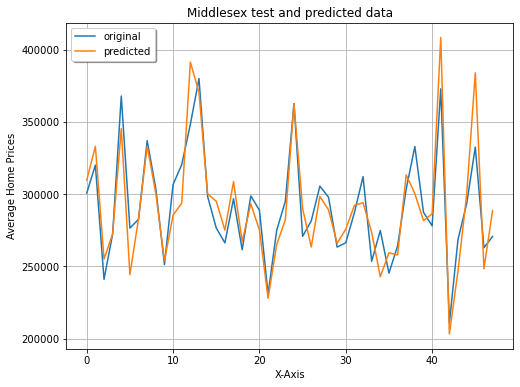

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     171.6
Date:                Mon, 17 May 2021   Prob (F-statistic):           5.35e-88
Time:                        09:51:46   Log-Likelihood:                -2635.3
No. Observations:                 240   AIC:                             5287.
Df Residuals:                     232   BIC:                             5314.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.212e+06   1.78e+06     -3.495      

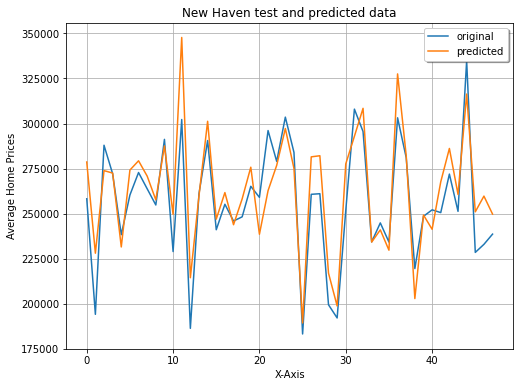

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     230.5
Date:                Mon, 17 May 2021   Prob (F-statistic):          1.08e-100
Time:                        09:51:46   Log-Likelihood:                -2607.8
No. Observations:                 240   AIC:                             5232.
Df Residuals:                     232   BIC:                             5259.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.441e+06   1.47e+06     -3.020      

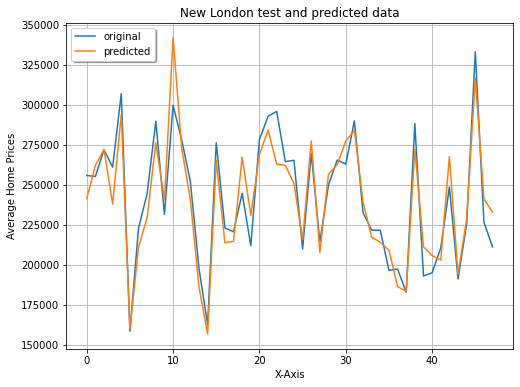

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     247.8
Date:                Mon, 17 May 2021   Prob (F-statistic):          7.08e-104
Time:                        09:51:46   Log-Likelihood:                -2553.4
No. Observations:                 240   AIC:                             5123.
Df Residuals:                     232   BIC:                             5151.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.831e+06   1.13e+06     -3.391      

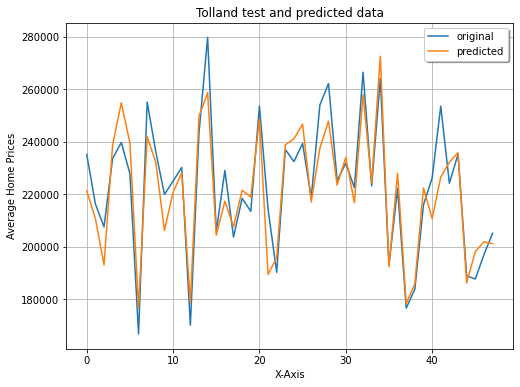

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     485.7
Date:                Mon, 17 May 2021   Prob (F-statistic):          1.02e-134
Time:                        09:51:47   Log-Likelihood:                -2497.9
No. Observations:                 240   AIC:                             5012.
Df Residuals:                     232   BIC:                             5040.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.412e+06   9.78e+05     -3.489      

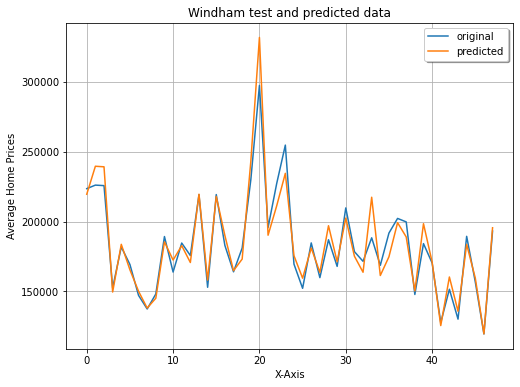

In [1109]:
for county, group in ct_sales.groupby('County'):
    X = group.copy()
    X.drop(columns=['County','Med_Price','Avg_Price'], inplace=True)
    X['Year'] = pd.DatetimeIndex(X['Year']).year
    X['us_per_cap'] = pd.to_numeric(X['us_per_cap'])
    X['Total_Sales'] = pd.to_numeric(X['Total_Sales'])
    y = group.Avg_Price.values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)
    lm = LinearRegression()
    r = lm.fit(X_train, y_train)
    pred = lm.predict(X_test)
    
    sm_x = X
    sm_y = y
    x2 = sm.add_constant(sm_x)
    est = sm.OLS(sm_y, x2)
    est2 = est.fit()
    print(est2.summary())
    
    mpl.figure(figsize=(8,6))
    x_ax = range(len(y_test))
    mpl.plot(x_ax, y_test, label="original")
    mpl.plot(x_ax, pred, label="predicted")
    mpl.title(f"{county} test and predicted data")
    mpl.xlabel('X-Axis')
    mpl.ylabel('Average Home Prices')
    mpl.legend(loc='best',fancybox=True, shadow=True)
    mpl.grid(True)
    mpl.show()

I went ahead and fit our models then predicted the average price. I gave the ordinary least squares regression results for each
county as well. It shows us our R-squared value which tells us the goodness of fit of our model. All the counties besides
Fairfield are above 0.80 so those models are pretty accurate. The Fairfield model is a little less accurate with a R-squared
value above 0.60.



## Part 5: Conclusion

When it comes to predicting the home values not just in Connecticut, but in the United States, it is important to take economic
factors into consideration. Is the country in a recession? Did the Federal Reserve cut interest rates further? How is the state
doing on GDP and in turn Per Capita? There are many more factors that I would have liked to include into the data, like school
district rankings, distance to big cities, and crime to make a more accurate model, but finding all the data that is needed is
pretty difficult. As shown from the data collection and cleaning part of the tutorial some of our values are missing and we have it account for it in some way that would not have too much of an impact on our model and give us phony results. After wrangling the data that was available and condensing it into one dataframe, I was able to come up with pretty accurate goodness of fit for the models and if I was given data for 2021, I think it would be safe to say the model would give a prediction that is pretty close to the actual home price. 


### Related Links

#### Data Sets
- [Federal Rates](https://www.macrotrends.net/2015/fed-funds-rate-historical-chart)
- [US GDP Growth Rate](https://www.macrotrends.net/countries/USA/united-states/gdp-growth-rate)
- [CT Population](https://www.macrotrends.net/states/connecticut/population)
- [CT Home Sales](https://www.chfa.org/about-us/ct-monthly-housing-market-dashboard/)

#### Data Science/Machine Learning
- [Linear Regression](https://ml-cheatsheet.readthedocs.io/en/latest/linear_regression.html#:~:text=Linear%20Regression%20is%20a%20supervised,Simple%20regression)
- [Ordinary Least Squares](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html)